In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!unzip 'gdrive/My Drive/archive (1).zip'


Streaming output truncated to the last 5000 lines.
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e345153-aed9-4879-a2cc-24f9dc5100e7___UF.GRC_YLCV_Lab 01798_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e37e8ad-3944-4e11-bc10-dd82616274d7___YLCV_NREC 2915_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e382244-fb3a-4caa-af71-05fff25f1c27___UF.GRC_YLCV_Lab 03397_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e3b9886-ce13-49d5-8f80-ccf4e5ddbeac___YLCV_GCREC 5479_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e615038-7a87-446a-a2cd-f76c5c75b6dd___YLCV_GCREC 5144_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e6938d9-1ab0-4728-993c-1069b66ce73b___UF.GRC_YLCV_Lab 02727_final_mas

In [4]:
pip install split-folders[full]

In [5]:
import splitfolders

In [6]:
input_file = 'plantvillage dataset/color'
output_file = 'plantvillage dataset splitted'

In [7]:
splitfolders.ratio(input_file,output=output_file,seed=42,ratio=(.7,.2,.1),group_prefix = None)

Copying files: 54305 files [00:47, 1153.12 files/s]


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator , img_to_array , load_img

In [9]:
len(os.listdir('/content/plantvillage dataset splitted/train'))

38

In [10]:
from keras.applications.vgg19 import VGG19 , preprocess_input , decode_predictions

In [11]:
train_datagen = ImageDataGenerator(zoom_range = 0.5 , shear_range = 0.3 , horizontal_flip = True)

val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [12]:
train = train_datagen.flow_from_directory(directory = '/content/plantvillage dataset splitted/train',target_size = (256,256), batch_size = 32)

val = val_datagen.flow_from_directory(directory = '/content/plantvillage dataset splitted/val',target_size = (256,256), batch_size = 32)

Found 37997 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


In [13]:
t_img , label = train.next()
t_img.shape

(32, 256, 256, 3)

In [14]:
def plottingImage(img_arr,label):
  for img, lbl in zip(img_arr,label):
    plt.figure(figsize=(5,5))
    img_array = img_to_array(img)
    img_array /=255.0
    plt.imshow(img_array)
    plt.show()

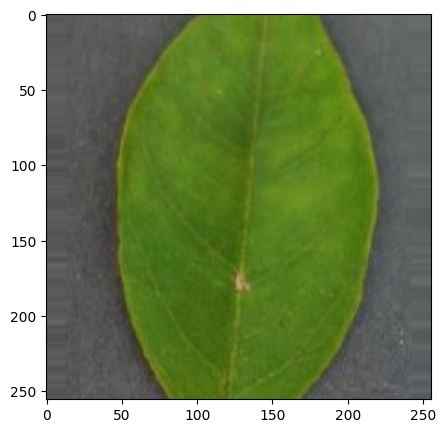

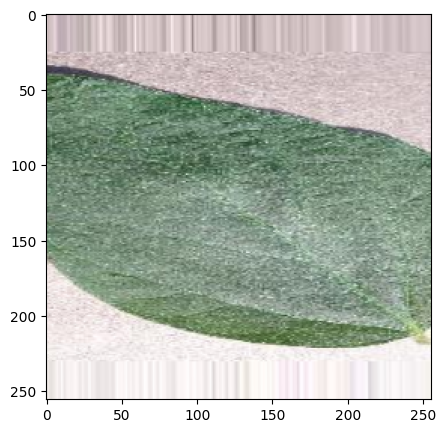

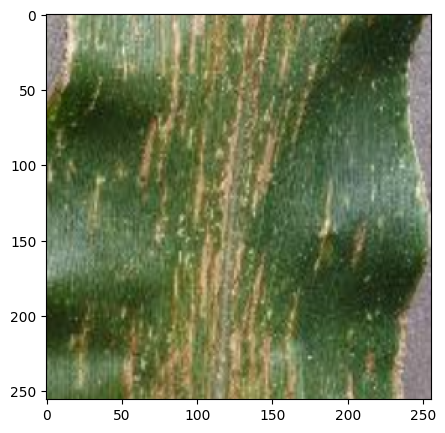

In [15]:
plottingImage(t_img[:3],label[:3])

In [16]:
from keras.layers import Dense,Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
import keras

In [17]:
base_model = VGG19(input_shape=(256,256,3),include_top =False)

for layer in base_model.layers:
  layer.trainable= False


80134624/80134624 [==============================] - 1s 0us/step


In [18]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [19]:
x = Flatten()(base_model.output)
x = Dense(units = 38 , activation = 'softmax')(x)

model = Model(base_model.input,x)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [22]:
model.compile(optimizer = 'adam',loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [23]:
from keras.callbacks import ModelCheckpoint , EarlyStopping

In [25]:
es = EarlyStopping(monitor = 'val_accuracy',min_delta = 0.01, patience = 3 , verbose=1)

mc = ModelCheckpoint(filepath='best_model.h5',monitor = 'val_accuracy',min_delta = 0.01, patience = 3 , verbose = 1 , save_best_only = True)

In [26]:
cb = [es,mc]

In [ ]:
his = model.fit_generator(train, steps_per_epoch = 16 , epochs = 50 , verbose = 1 , callbacks = cb ,  validation_data = val , validation_steps = 16)

<ipython-input-27-430125164e4d>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  his = model.fit_generator(train, steps_per_epoch = 16 , epochs = 50 , verbose = 1 , callbacks = cb ,  validation_data = val , validation_steps = 16)


Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 33.6073 - accuracy: 0.3008 
Epoch 1: val_accuracy improved from -inf to 0.45312, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 1133s 72s/step - loss: 33.6073 - accuracy: 0.3008 - val_loss: 14.5450 - val_accuracy: 0.4531
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 20.8335 - accuracy: 0.4727 
Epoch 2: val_accuracy improved from 0.45312 to 0.55469, saving model to best_model.h5
16/16 [==============================] - 981s 63s/step - loss: 20.8335 - accuracy: 0.4727 - val_loss: 10.1344 - val_accuracy: 0.5547
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 18.1158 - accuracy: 0.5449 
Epoch 3: val_accuracy improved from 0.55469 to 0.56055, saving model to best_model.h5
16/16 [==============================] - 974s 63s/step - loss: 18.1158 - accuracy: 0.5449 - val_loss: 10.5570 - val_accuracy: 0.5605
Epoch 4/50
16/16 [==============================] - ETA: 0s - loss: 14.9745 - accuracy: 0.6465 
Epoch 4: val_accuracy did not improve from 0.56055
16/16 [==============================] - 984s 64s/step - loss: 14.9745 - accuracy: 0.6465

In [ ]:
h = his.history
h.keys()

In [ ]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'],c='red')

plt.tite('Accuracy vs Val Accuracy')
plt.show()

In [ ]:
from keras.models import load_model
model = load_model('/content/base_model.h5')

In [ ]:
acc = model.evaluate_generator(val)[1]
print(f'the accuracy of model is: {acc*100}%')

In [ ]:
train.class_indices

In [ ]:
list(train.class_indices.values()),list(train.class_indices.keys())

In [ ]:
ref = dict(zip(list(train.class_indices.values()),list(train.class_indices.keys())))

In [ ]:
def prediction(path):
  img = load_img(path,target_size=(256,256))
  i = img_to_array(img)
  im = preprocess_input(i)
  img = np.expand_dims(im,axis=0)
  pred = np.argmax(model.predict(img))
  print(f'This image belongs to {ref[pred]}')

In [ ]:
path = '/content/plantvillage dataset splitted/test/Strawberry___leaf_scorch/1081bac8-4ff2-4025-8328-446284666d47___R5_L.Scorch 1171.JPG'
prediction(path)